In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score, recall_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

### Import des jeux de données

In [3]:
X = pd.read_csv("../Data/X.csv")
y = pd.read_csv("../Data/y.csv")

### Séparation et on enlève l'ID employé, + stratification pour sécuriser le test

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.drop(columns=['id_employee'])
X_test = X_test.drop(columns=['id_employee'])


### Vérification des dimensions

In [5]:
print(f"Train : {X_train.shape}")
print(f"Test  : {X_test.shape}")

Train : (1176, 41)
Test  : (294, 41)


GridSearch sur RandomForest

In [6]:
# Sélection du modèle
rf = RandomForestClassifier(random_state=42)

# Paramètres
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],       
    'max_depth': [None, 10, 20, 30, 40, 50],    # Teste différentes profondeurs limites + illimité
    'min_samples_split': [2, 5, 10],            # Nuance la fragmentation des noeuds
    'min_samples_leaf': [1, 2, 4, 6],           # Nuance la taille des feuilles
    'max_features': ['sqrt', 'log2'],           # Méthode de sélection des features
    'bootstrap': [True, False],                 # Avec ou sans remise
    'class_weight': ['balanced',]               # Gestion du déséquilibre obligatoire
}

# Configuration
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)


### Exécution

In [7]:
print("Lancement de la grid search")
grid_search.fit(X_train, y_train.values.ravel())

Lancement de la grid search
Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'class_weight': ['balanced'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], ...}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


### Résultats

In [8]:

print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score balanced_accuracy : {grid_search.best_score_:.3f}")

best_rf = grid_search.best_estimator_

Meilleurs paramètres : {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 50}
Meilleur score balanced_accuracy : 0.690


### Cross Validation

In [9]:

cv_results = pd.DataFrame(grid_search.cv_results_)
best_idx = grid_search.best_index_
mean_score = cv_results.loc[best_idx, 'mean_test_score']
std_score = cv_results.loc[best_idx, 'std_test_score']

print(f"Validation Croisée (5 folds) : {mean_score:.3f} (+/- {std_score:.3f})")
if std_score > 0.05:
    print("Attention : Variance élevée")

Validation Croisée (5 folds) : 0.690 (+/- 0.035)


### Analyse des résultats du GridSearch

In [10]:

results = pd.DataFrame(grid_search.cv_results_)
best_res = results.loc[grid_search.best_index_]

print(f"Score moyen (Balanced Acc) : {best_res['mean_test_score']:.3f}")
print(f"Écart-type (Std) : {best_res['std_test_score']:.3f}")

# Interprétation rapide
if best_res['std_test_score'] > 0.05:
    print("ATTENTION : Le modèle est instable (écart-type élevé).")
else:
    print("Le modèle est stable sur les différents plis (folds).")

Score moyen (Balanced Acc) : 0.690
Écart-type (Std) : 0.035
Le modèle est stable sur les différents plis (folds).


## 1. Calcul des probabilités
Au lieu de demander au modèle une classification binaire directe (0 ou 1), nous récupérons les **probabilités** (le score de suspicion d'un départ). Cela nous permettra d'ajuster nous-mêmes le curseur de sensibilité.

In [11]:
# Récupérer les probabilités (et non les classes 0/1 directes)
y_scores = best_rf.predict_proba(X_test)[:, 1]

# Calcul de la courbe Précision-Rappel
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

## 2. Optimisation du Seuil (Threshold Tuning)
Nous cherchons d'abord le seuil mathématique qui maximise le **F1-Score**.
Ensuite, nous appliquons une **correction métier** : nous abaissons ce seuil de 15% (`* 0.85`).

**Objectif :** Rendre le modèle plus "agressif" pour privilégier le **Rappel** (détecter un maximum de démissionnaires), quitte à perdre un peu en Précision.

In [12]:
# Calcul du F1-score pour chaque seuil possible
fscore = (2 * precision * recall) / (precision + recall)

# Localiser l'index du meilleur F1
ix = np.argmax(fscore)

print(f"Seuil mathématique optimal (F1) : {thresholds[ix]:.3f}")

# Application de la stratégie métier (plus agressif)
seuil_manuel = thresholds[ix] * 0.85 
print(f"Seuil manuel appliqué (Plus agressif) : {seuil_manuel:.3f}")

Seuil mathématique optimal (F1) : 0.450
Seuil manuel appliqué (Plus agressif) : 0.382


## 3. Évaluation Finale
Nous appliquons le seuil manuel pour générer les prédictions finales (0 ou 1) et affichons la matrice de confusion.

In [13]:
# Application du seuil manuel pour décider qui part (1) ou reste (0)
y_pred_final = (y_scores >= seuil_manuel).astype(int)

print("\n=== Matrice de Confusion FINALE (Optimisée Détection) ===")
# On utilise y_pred_final, pas y_pred_optimal
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

print("\n=== Rapport complet ===")
print(classification_report(y_test, y_pred_final))


=== Matrice de Confusion FINALE (Optimisée Détection) ===
[[189  58]
 [ 19  28]]

=== Rapport complet ===
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       247
           1       0.33      0.60      0.42        47

    accuracy                           0.74       294
   macro avg       0.62      0.68      0.63       294
weighted avg       0.82      0.74      0.77       294



### Représentation visuelle

Seuil optimal identifié : 0.450 (Max F1-Score : 0.447)


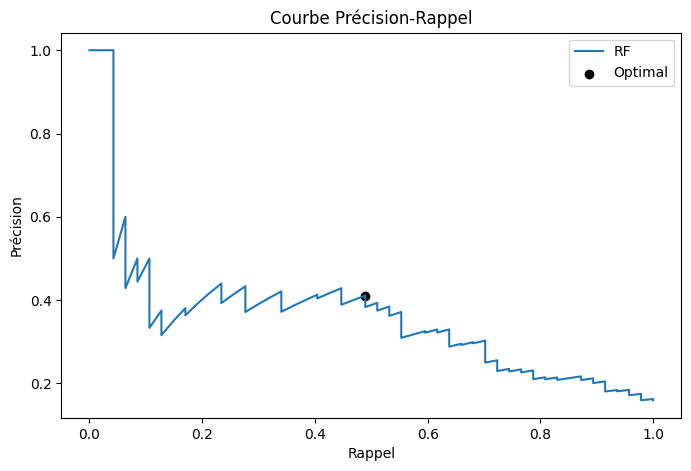

In [14]:

# Prédiction des probabilités
y_probs = best_rf.predict_proba(X_test)[:, 1]

# Calcul de la courbe et du F-Score
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
fscores = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscores)
best_thresh = thresholds[ix]

print(f"Seuil optimal identifié : {best_thresh:.3f} (Max F1-Score : {fscores[ix]:.3f})")

# Visualisation
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='RF')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Optimal')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe Précision-Rappel')
plt.legend()
plt.show()

### Initialisation et Calcul des valeurs SHAP

In [15]:

shap.initjs()

print("Calcul des valeurs SHAP (Méthode moderne)...")
# explainer
explainer = shap.TreeExplainer(best_rf)

# 2. Calcul de l'objet Explanation
shap_object = explainer(X_test)

# On isole la CLASSE 1 (Démission)

if len(shap_object.shape) == 3:
    shap_class1 = shap_object[:, :, 1]
else:
    shap_class1 = shap_object

Calcul des valeurs SHAP (Méthode moderne)...


### Validation : Comparaison Permutation vs SHAP

In [18]:
print("\n=== Comparaison : Permutation Importance vs SHAP ===")

# Calcul Permutation (sklearn)
perm_imp = permutation_importance(best_rf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame(perm_imp.importances_mean, index=X_test.columns, columns=['Permutation'])

# Calcul SHAP Importance (Moyenne absolue des valeurs)
shap_df = pd.DataFrame(np.abs(shap_class1.values).mean(axis=0), index=X_test.columns, columns=['SHAP'])

# Affichage comparatif (Top 5)
comparison = pd.concat([perm_df.sort_values('Permutation', ascending=False).head(5), shap_df.sort_values('SHAP', ascending=False).head(5)], axis=1)

display(comparison)



=== Comparaison : Permutation Importance vs SHAP ===


,Permutation,SHAP
heure_supplementaires_Oui,0.028571,0.054817
frustration_trajet,0.012925,NaN
augmentation_salaire_pourcentage,0.005442,NaN
note_evaluation_actuelle,0.005442,NaN
delta_evaluation,0.004762,NaN
taux_volatilite,NaN,0.057757
age,NaN,0.032970
revenu_mensuel,NaN,0.031863
nombre_participation_pee,NaN,0.031223


### Analyse Globale (Beeswarm Plot)


=== Summary Plot (Global) ===


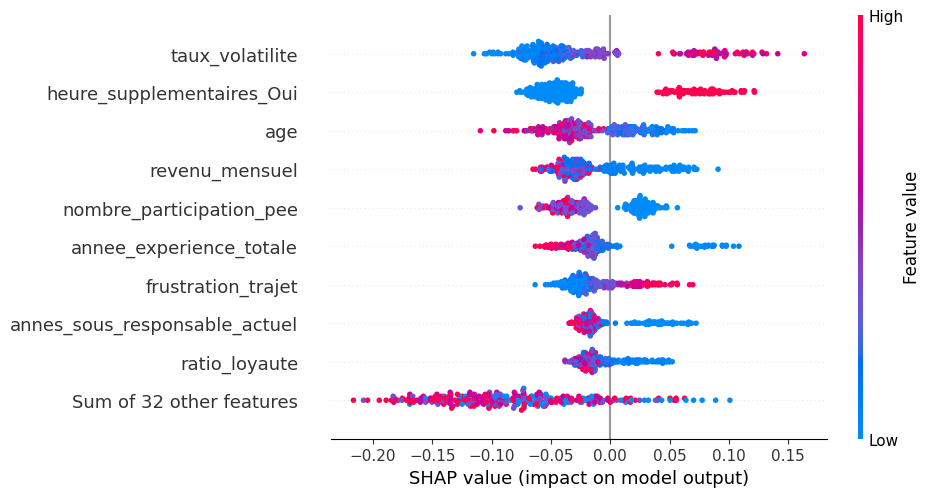

In [19]:
# Beeswarm
print("\n=== Summary Plot (Global) ===")
# shap.plots.beeswarm est la nouvelle fonction dédiée à l'objet Explanation
plt.figure()
shap.plots.beeswarm(shap_class1, max_display=10, show=False)
plt.show()

### Zoom sur la variable principale


=== Scatter Plot pour la variable : taux_volatilite ===


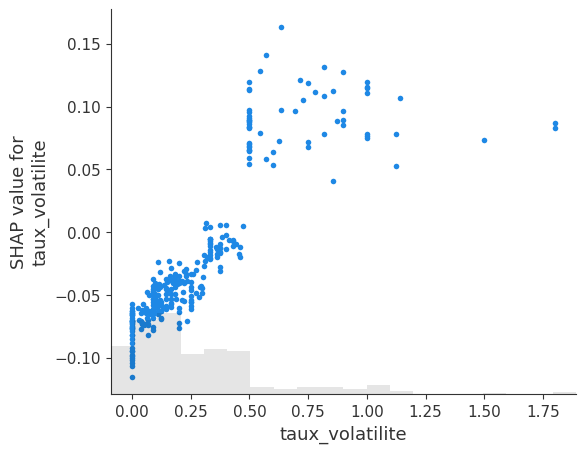

In [20]:
# On prend la variable la plus importante (index 0 du df trié)
top_feature_name = shap_df.sort_values('SHAP', ascending=False).index[0]
print(f"\n=== Scatter Plot pour la variable : {top_feature_name} ===")


shap.plots.scatter(shap_class1[:, top_feature_name])

### Analyse Locale (Waterfall Plot)


=== Analyse Locale : Comparaison Départ vs Reste ===
--- Employé Fidèle (Index 0) ---


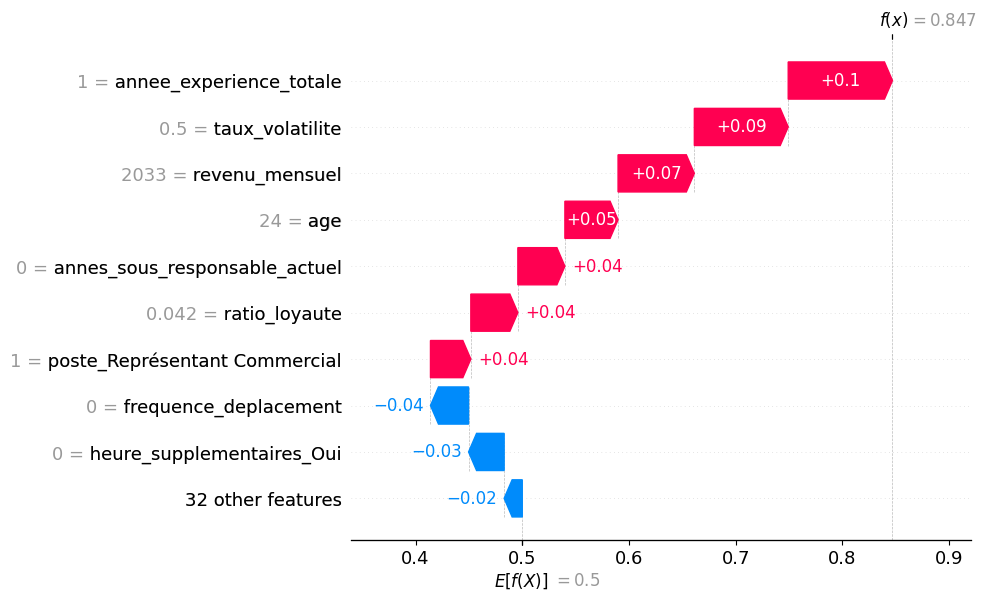

--- Employé Démissionnaire (Index 4) ---


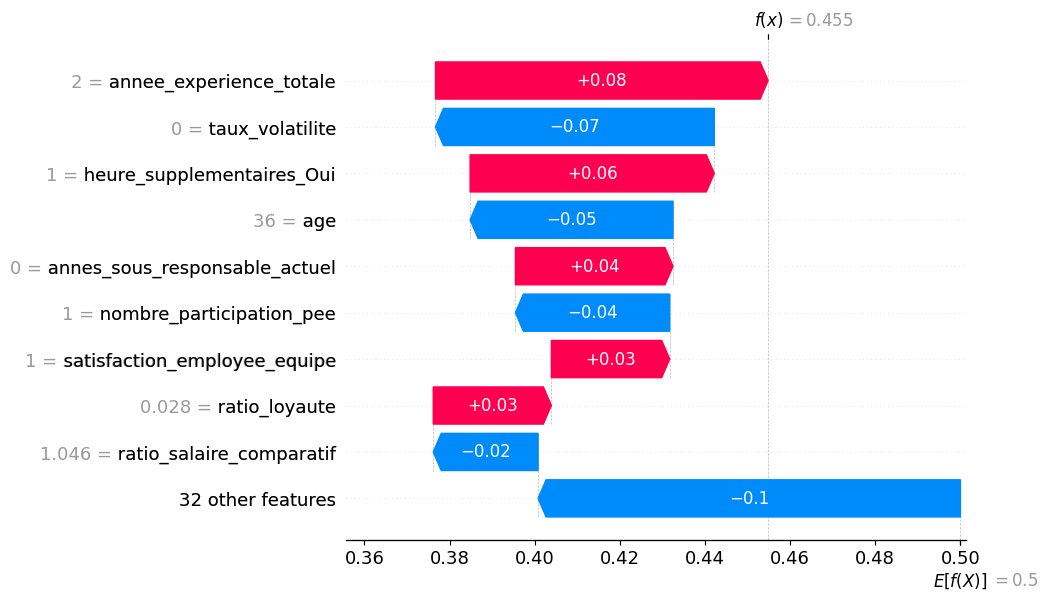

In [21]:
# Waterfall
print("\n=== Analyse Locale : Comparaison Départ vs Reste ===")

# Récupération des indices pour l'exemple
y_arr = y_test.values.ravel() if hasattr(y_test, 'values') else y_test
idx_stay = np.where(y_arr == 0)[0][0]  # Premier qui reste
idx_leave = np.where(y_arr == 1)[0][0] # Premier qui part

print(f"--- Employé Fidèle (Index {idx_stay}) ---")


shap.plots.waterfall(shap_class1[idx_stay])

print(f"--- Employé Démissionnaire (Index {idx_leave}) ---")
shap.plots.waterfall(shap_class1[idx_leave])